In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [4]:
import re
import string
import emoji
import csv
import tweepy
import time
import keras
from keras.layers import Dense, LSTM, Embedding, Conv1D, MaxPooling1D, GRU, Dropout, Bidirectional
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from transformers import pipeline

In [10]:
kc="Enter your Consumer Key(API Key)"
sc="Enter your Consumer Secret Key(API Secret Key)"
ta="Enter you Access Token"
sta="Enter your Access Secret"

au=tweepy.OAuthHandler(kc,sc)
au.set_access_token(ta,sta)
api = tweepy.API(au,wait_on_rate_limit=True)

hashtags = ['#ncsu','#ncstate','#gopack','#thinkanddo','#1pack1goal','#wpn','#wolfpack','#gowolfpack','#packpride',
            '#ncstate23','#strengthinthepack','#pack9','#NCStateVetMed','#PackMentality','#CALSPack','#HowlBack',
            '#HuntLibrary','#DHHill','#PackRisin','#ncstatefootball','#ncstatebasketball','#packathletics', 
            '#wolfpacknation','#wolfpackworldwide','#PackPros','#HTT']

twe=[]
listTwee=[]
for h in hashtags:
    print(f"Getting tweets for {h}")
    time.sleep(10)
    for tw in tweepy.Cursor(api.search_tweets,q=h,lang='en',tweet_mode='extended',count=1000).pages(500):
        for result in tw:
            tweet_data = {}
            if 'retweeted_status' in dir(result):
                tweet_data['text'] = result.retweeted_status.full_text
            else:
                tweet_data['text'] = result.full_text
            tweet_data['user'] = result.user.screen_name
            tweet_data['date'] = result.created_at.date()
            tweet_data['time'] = result.created_at.time()
            if tweet_data['text'] not in listTwee:
                listTwee.append(tweet_data['text'])
            else:
                continue
            if tweet_data not in twe:
                twe.append(tweet_data)
    print(f"Total of {len(twe)} tweets were fetched")

Getting tweets for #ncsu
Total of 32 tweets were fetched
Getting tweets for #ncstate
Total of 122 tweets were fetched
Getting tweets for #gopack
Total of 356 tweets were fetched
Getting tweets for #thinkanddo
Total of 387 tweets were fetched
Getting tweets for #1pack1goal
Total of 405 tweets were fetched
Getting tweets for #wpn
Total of 464 tweets were fetched
Getting tweets for #wolfpack
Total of 1213 tweets were fetched
Getting tweets for #gowolfpack
Total of 1221 tweets were fetched
Getting tweets for #packpride
Total of 1272 tweets were fetched
Getting tweets for #ncstate23
Total of 1383 tweets were fetched
Getting tweets for #strengthinthepack
Total of 1390 tweets were fetched
Getting tweets for #pack9
Total of 1537 tweets were fetched
Getting tweets for #NCStateVetMed
Total of 1556 tweets were fetched
Getting tweets for #PackMentality
Total of 1651 tweets were fetched
Getting tweets for #CALSPack
Total of 1652 tweets were fetched
Getting tweets for #HowlBack
Total of 1655 tweets 

In [13]:
print(len(listTwee))
for tweet in twe:
    print(f"{tweet['user']} ({tweet['date']} {tweet['time']}): {tweet['text']}")

1743
EddieDi31034679 (2023-05-06 18:38:28): Congrats #NCState23! We’ll miss you on Tuesday nights. We wish you much happiness &amp; success in your life journey. See you down the road for #NCSU Homecoming and 🏈🏀⚾️ game days. #GoPack https://t.co/oloIIWLy3F
DonnaTwiford (2023-05-06 16:29:43): Time to celebrate those new N.C. State Alumni!
https://t.co/18WCm7hxFf 

#ncsu #raleigh #graduationgift #belltower #wolfpack #thyhonoredshrine #graduation2023
redlinebeerand1 (2023-05-06 15:03:08): Happy Commissioning 🇺🇸 + Graduation Spring 2023 @keegels_101 @mikey_sal13 👨‍🎓 

Red Line Fam is proud of you 👏 🎓
.
.
.
#ncsu #ncstate #murica🇺🇸 #ncsugraduation2023 https://t.co/YA8CIAqc1g https://t.co/tAjElLpXXb
ZenithRaleigh (2023-05-06 02:15:28): New tequila flavors means new margaritas! Now featuring #21seedstequila Jalapeño/Cucumber and Valencia Orange. Whether you want a spicy kick or something crisp and refreshing, we’ve got you covered. #Downtownraleigh #fayettevillestreet #ncstate #ncsu #cincodem

In [14]:
print(len(twe))
print(twe[0])

1743
{'text': 'Congrats #NCState23! We’ll miss you on Tuesday nights. We wish you much happiness &amp; success in your life journey. See you down the road for #NCSU Homecoming and 🏈🏀⚾️ game days. #GoPack https://t.co/oloIIWLy3F', 'user': 'EddieDi31034679', 'date': datetime.date(2023, 5, 6), 'time': datetime.time(18, 38, 28)}


In [16]:
with open('FinalTweets.csv', 'w', encoding='utf-8', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['User', 'Date', 'Time', 'Text'])
    for tweet in twe:
        writer.writerow([tweet['user'], tweet['date'], tweet['time'], tweet['text']])

In [18]:
stop_words=set(stopwords.words('english'))
twee_pro=[]
non_english=re.compile('[^a-zA-Z\s]')
for tweet in twe:
    twee_tx= re.sub(r'https?:\/\/.*[\r\n]*', '', tweet['text'], flags=re.MULTILINE)
    twee_tx= re.sub(r'@[A-Za-z0-9_]+|[#]', '', twee_tx)
    twee_tx= twee_tx.translate(str.maketrans('', '', string.punctuation))
    twee_tx= emoji.demojize(twee_tx)
    twee_tx= re.sub(r':[a-z_]+:', '', twee_tx)
    twee_tx= non_english.sub('', twee_tx)
    twee_tx= twee_tx.lower()
    words = word_tokenize(twee_tx)
    words = [word for word in words if not word in stop_words]
    twee_proc = ' '.join(words)
    twee_pro_dict = {'user': tweet['user'], 'date': tweet['date'], 'time': tweet['time'], 'text': twee_proc}
    twee_pro.append(twee_pro_dict)

print("Length: ",len(twee_pro))
for tweet in twee_pro:
    print(f"{tweet['user']} ({tweet['date']} {tweet['time']}): {tweet['text']}")


Length:  1743
EddieDi31034679 (2023-05-06 18:38:28): congrats ncstate well miss tuesday nights wish much happiness amp success life journey see road ncsu homecoming game days gopack
DonnaTwiford (2023-05-06 16:29:43): time celebrate new nc state alumni ncsu raleigh graduationgift belltower wolfpack thyhonoredshrine graduation
redlinebeerand1 (2023-05-06 15:03:08): happy commissioning unitedstates graduation spring red line fam proud ncsu ncstate muricaunitedstates ncsugraduation
ZenithRaleigh (2023-05-06 02:15:28): new tequila flavors means new margaritas featuring seedstequila jalapeocucumber valencia orange whether want spicy kick something crisp refreshing weve got covered downtownraleigh fayettevillestreet ncstate ncsu cincodemayo margarita
packswimdive (2023-05-05 22:41:17): congratulations graduating studentathletes class excellence wolfpack athletics ncsu
EddieDi31034679 (2023-05-05 20:41:17): new floor bar time ncsu graduation
earlyb1rd_tweet (2023-05-05 01:28:17): rough inning

In [22]:
v=CountVectorizer()
mat_Bow= v.fit_transform([tweet['text'] for tweet in twee_pro])
tfidf_transformer= TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(mat_Bow)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=v.get_feature_names())

classifier = pipeline('sentiment-analysis')

for i, tweet in enumerate(twee_pro):
    text = tweet['text']
    label = classifier(text)[0]['label']
    twee_pro[i]['sentiment'] = label

for tweet in twee_pro:
    print(f"{tweet['user']} ({tweet['date']} {tweet['time']}) [{tweet['sentiment']}]: {tweet['text']}")


C:\Users\bhanu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This 

EddieDi31034679 (2023-05-06 18:38:28) [NEGATIVE]: congrats ncstate well miss tuesday nights wish much happiness amp success life journey see road ncsu homecoming game days gopack
DonnaTwiford (2023-05-06 16:29:43) [POSITIVE]: time celebrate new nc state alumni ncsu raleigh graduationgift belltower wolfpack thyhonoredshrine graduation
redlinebeerand1 (2023-05-06 15:03:08) [POSITIVE]: happy commissioning unitedstates graduation spring red line fam proud ncsu ncstate muricaunitedstates ncsugraduation
ZenithRaleigh (2023-05-06 02:15:28) [NEGATIVE]: new tequila flavors means new margaritas featuring seedstequila jalapeocucumber valencia orange whether want spicy kick something crisp refreshing weve got covered downtownraleigh fayettevillestreet ncstate ncsu cincodemayo margarita
packswimdive (2023-05-05 22:41:17) [POSITIVE]: congratulations graduating studentathletes class excellence wolfpack athletics ncsu
EddieDi31034679 (2023-05-05 20:41:17) [POSITIVE]: new floor bar time ncsu graduation

In [23]:
import pickle
with open('Bhanu-sentiment-pipeline.txt','wb') as fc:
    pickle.dump(classifier,fc)

C:\Users\bhanu\anaconda3\lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [24]:
pos=0
neg=0
for t in twee_pro:
    if(t['sentiment']=='POSITIVE'):
        pos+=1
    else:
        neg+=1
print("Total positive: ",pos)
print("Total negative: ",neg)

Total positive:  989
Total negative:  754


In [25]:
with open('FinalTweetsSentiment.csv', 'w', encoding='utf-8', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['User', 'Date', 'Time', 'Text', 'Sentiment'])
    for tweet in twee_pro:
        writer.writerow([tweet['user'], tweet['date'], tweet['time'], tweet['text'], tweet['sentiment']])

In [40]:
t=Tokenizer()
t.fit_on_texts([tweet['text'] for tweet in twee_pro])
sequences = t.texts_to_sequences([tweet['text'] for tweet in twee_pro])

max_length = max([len(seq) for seq in sequences])
seq_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
labels = [1 if tweet['sentiment'] == 'POSITIVE' else 0 for tweet in twee_pro]

X_train, X_test, y_train, y_test = train_test_split(seq_pad, labels, test_size=0.2, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)

m= Sequential()
m.add(Embedding(input_dim=len(t.word_index)+1, output_dim=300, input_length=max_length))
m.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
m.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
m.add(MaxPooling1D(pool_size=2))
m.add(Dropout(0.2))
#m.add(Bidirectional(LSTM(128, return_sequences=True)))
m.add(Bidirectional(LSTM(64)))
m.add(Dense(64, activation='relu'))
m.add(Dense(32, activation='relu'))
m.add(Dropout(0.2))
m.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(lr=0.001)
m.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=1e-6)

m.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr])

test_loss, test_acc = m.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


Epoch 1/50


C:\Users\bhanu\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


22/22 [==============================] - 13s 208ms/step - loss: 0.6858 - accuracy: 0.5531 - val_loss: 0.6683 - val_accuracy: 0.5960 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - 3s 118ms/step - loss: 0.6262 - accuracy: 0.6349 - val_loss: 0.5602 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - 3s 116ms/step - loss: 0.3225 - accuracy: 0.8924 - val_loss: 0.6341 - val_accuracy: 0.6991 - lr: 0.0010
Epoch 4/50
22/22 [==============================] - 3s 117ms/step - loss: 0.1459 - accuracy: 0.9505 - val_loss: 0.6703 - val_accuracy: 0.7020 - lr: 1.0000e-04
Epoch 5/50
22/22 [==============================] - 3s 116ms/step - loss: 0.1287 - accuracy: 0.9598 - val_loss: 0.6759 - val_accuracy: 0.7020 - lr: 1.0000e-05
Epoch 6/50
22/22 [==============================] - 3s 115ms/step - loss: 0.1287 - accuracy: 0.9627 - val_loss: 0.6765 - val_accuracy: 0.7020 - lr: 1.0000e-06
Epoch 7/50
11/11 [==============================] - 0s 23ms/step - l

11/11 [==============================] - 2s 21ms/step
Accuracy: 0.7020057306590258
Precision: 0.7549019607843137
Recall: 0.7403846153846154
F1-score: 0.7475728155339806


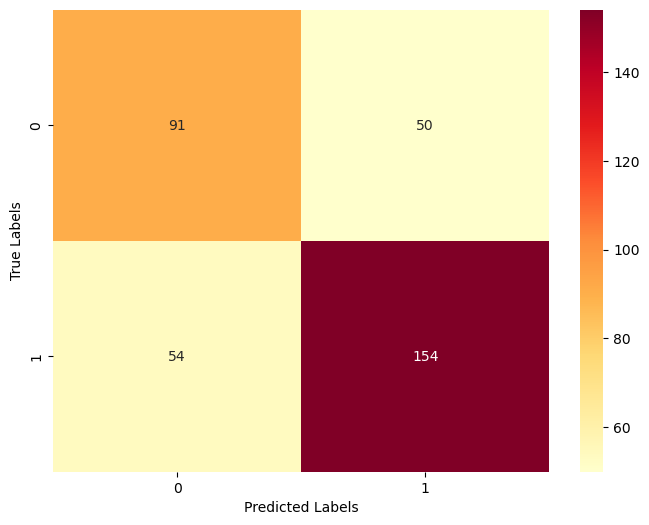

In [41]:
y_pred = m.predict(X_test)
y_pred = [1 if x>0.5 else 0 for x in y_pred]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [42]:
r=classification_report(y_test, y_pred)
print(r)

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       141
           1       0.75      0.74      0.75       208

    accuracy                           0.70       349
   macro avg       0.69      0.69      0.69       349
weighted avg       0.70      0.70      0.70       349



In [50]:
def sent_preproce(tx):
    tx = tx.lower()
    tx = re.sub(r'https?:\/\/.*[\r\n]*', '',tx, flags=re.MULTILINE)
    tx = re.sub(r'@[A-Za-z0-9_]+|[#]', '',tx)
    tx = tx.translate(str.maketrans("", "", string.punctuation))
    tx = emoji.demojize(tx)
    tx = re.sub(r':[a-z_]+:', '', tx)
    tx = non_english.sub('', tx)
    stop_words = set(stopwords.words('english'))
    tx = " ".join([word for word in tx.split() if word not in stop_words])
    tokenized_sentence = t.texts_to_sequences([tx])
    padded_sentence = pad_sequences(tokenized_sentence, maxlen=100, padding='post')
    return padded_sentence

sents= [    
    "I love going to university every day and learning new things.",    
    "The professors at my university are incredibly knowledgeable and passionate about their subjects.",    
    "The campus at my university is beautiful and well-maintained.",    
    "I am grateful for the opportunities that my university has provided me.",    
    "The student community at my university is friendly and welcoming.",    
    "My university is a complete worth it.",    
    "The professors at my university are very educated.",    
    "The workload at my university is intolerable, making it nearly impossible to cope with.",
    "I absolutely despise this college.",
    "Attending university has been a total waste of time and money, and I regret every moment of it."]

for sentence in sents:
    padded_sentence = sent_preproce(sentence)
    p = m.predict(padded_sentence)[0][0]
    sentiment = "Positive" if p > 0.5 else "Negative"
    print(f"Sentence: {sentence}\nPrediction: {p:.4f}\nSentiment: {sentiment}\n")


1/1 [==============================] - 0s 63ms/step
Sentence: I love going to university every day and learning new things.
Prediction: 0.8643
Sentiment: Positive

1/1 [==============================] - 0s 78ms/step
Sentence: The professors at my university are incredibly knowledgeable and passionate about their subjects.
Prediction: 0.8116
Sentiment: Positive

1/1 [==============================] - 0s 63ms/step
Sentence: The campus at my university is beautiful and well-maintained.
Prediction: 0.9395
Sentiment: Positive

1/1 [==============================] - 0s 72ms/step
Sentence: I am grateful for the opportunities that my university has provided me.
Prediction: 0.6514
Sentiment: Positive

1/1 [==============================] - 0s 72ms/step
Sentence: The student community at my university is friendly and welcoming.
Prediction: 0.8225
Sentiment: Positive

1/1 [==============================] - 0s 64ms/step
Sentence: My university is a complete worth it.
Prediction: 0.7056
Sentiment: 